<a href="https://colab.research.google.com/github/parkmicheal1114/Python_Quest/blob/main/Exploration/ControllNet/ControlNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- ref: https://huggingface.co/docs/diffusers/v0.17.1/en/api/pipelines/controlnet

In [1]:
# Stable Diffusion 설치
!pip install --upgrade -qq git+https://github.com/huggingface/diffusers.git transformers accelerate

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 43.8 MB/s eta 0:00:00


# 외곽선 검출
 - Canny 알고리즘을 사용한다.

In [2]:
# SD , torch
import torch
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image

# image edit , np
import cv2
from PIL import Image
import numpy as np


In [4]:
# 이미지 불러오기
image = load_image(
    "https://dynamic-media-cdn.tripadvisor.com/media/photo-o/14/b5/9c/6f/le-sky.jpg?w=500&h=400&s=1"
)

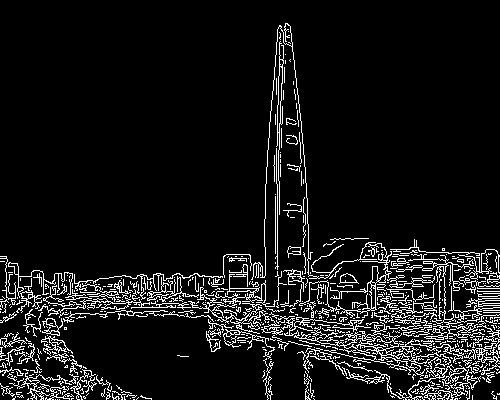

In [5]:
# 이미지 윤관선 검출

# 이미지를 NumPy 배열로 변환합니다.
image = np.array(image)

# threshold를 지정합니다.
low_threshold = 100
high_threshold = 200

# 윤곽선을 검출합니다.
image = cv2.Canny(image, low_threshold, high_threshold)

image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image) # 이미지를 NumPy 배열로 변환합니다.
canny_image

In [6]:
# 윤곽선 검출 전처리기를 사용한 모델 파이프라인

from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
canny_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=canny_controlnet, torch_dtype=torch.float16
)


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


Token indices sequence length is longer than the specified maximum sequence length for this model (92 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['drift across the clear sky, adding to the sense of wonder and adventure.']


  0%|          | 0/50 [00:00<?, ?it/s]

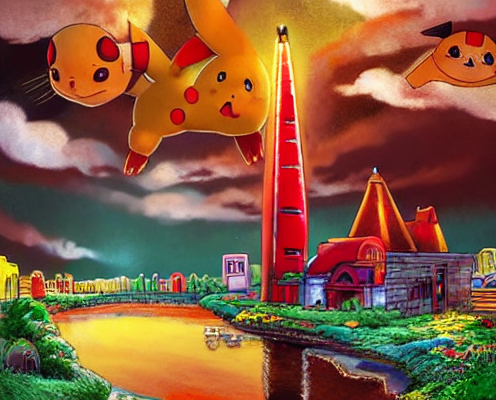

In [7]:
from diffusers import UniPCMultistepScheduler

canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
canny_pipe = canny_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 지정합니다.
generator = torch.manual_seed(0)

# 이미지를 생성합니다.
canny_image = canny_pipe(
  prompt="Pikachu and Charmander playfully chase each other in a cartoon-like village, amidst colorful houses and whimsical landscapes. The vibrant and dynamic lighting captures the joyful atmosphere of their antics. The scene is painted in the style of Hayao Miyazaki's Studio Ghibli, with high definition and detailed textures that bring out the pastel and warm hues of orange and yellow. Fluffy clouds drift across the clear sky, adding to the sense of wonder and adventure.",
  negative_prompt= 'low contrast, unrealistic lighting, flat textures, poorly drawn, draft, grainy, poor quality, mismatched colors',
  num_inference_steps=50,
  generator=generator,
  image=canny_image).images[0]

# 생성된 이미지를 저장합니다.
canny_image.save("./sample.png")

# 생성된 이미지를 출력합니다.
canny_image

# Human Pose

In [8]:
# controlnet-aux를 설치합니다. Human pose를 검출해주는 controlnet의 보조용 모델입니다.
!pip install controlnet-aux==0.0.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.5 MB/s eta 0:00:00


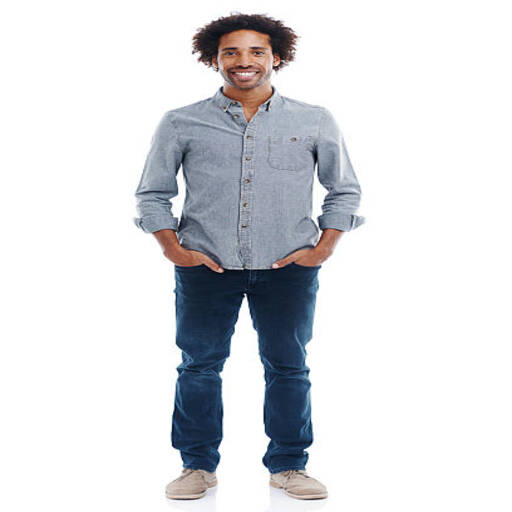

In [9]:
openpose_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)
openpose_image

cuda


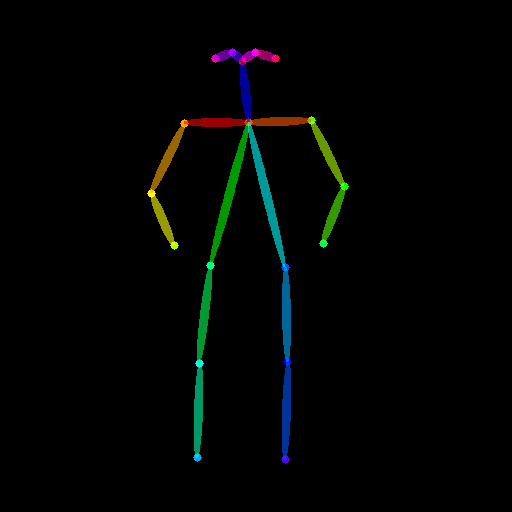

In [10]:
from controlnet_aux import OpenposeDetector

# 인체의 자세를 검출하는 사전 학습된 ControlNet 불러오기
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

# 이미지에서 자세 검출
openpose_image = openpose(openpose_image)
openpose_image

In [11]:
# openpose  사용한 모델 파이프라인
openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
openpose_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=openpose_controlnet, torch_dtype=torch.float16
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [12]:
torch.cuda.empty_cache()

Token indices sequence length is longer than the specified maximum sequence length for this model (94 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['vibrant color scheme with dynamic lighting adds a sense of wonder and delight to the artwork.']


  0%|          | 0/30 [00:00<?, ?it/s]

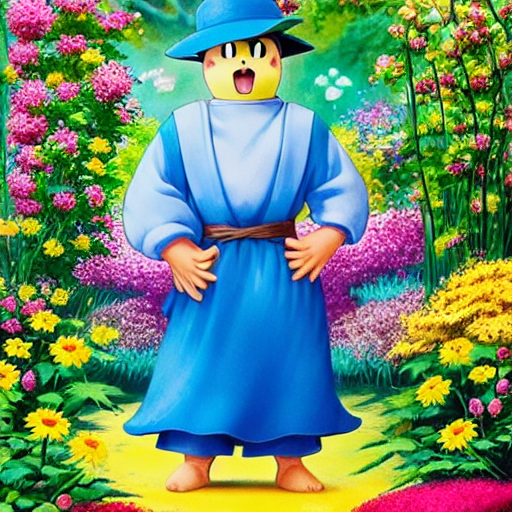

In [13]:
openpose_pipe.scheduler = UniPCMultistepScheduler.from_config(openpose_pipe.scheduler.config)
openpose_pipe = openpose_pipe.to("cuda")

# Q. 코드를 작성해 보세요.
# 동일한 이미지를 생성하기 위해 seed를 넣어줍니다.
generator = torch.manual_seed(5)

#프롬프트를 작성합니다.
prompt="Pikachu is joyfully playing amidst a sea of vibrant flowers in a lush and enchanting garden. The soft and dappled lighting creates a warm and inviting atmosphere, with the sun casting playful shadows. The scene is rendered in the fantasy style of Hayao Miyazaki, known for his whimsical and imaginative worlds. The watercolor medium captures the magic of the moment, and the pastel and vibrant color scheme with dynamic lighting adds a sense of wonder and delight to the artwork."
negative_prompt = "blurry, distorted proportions, unrealistic colors, flat textures, poor quality, bad anatomy, awkward pose, muddy colors, mismatched lighting, rough brush strokes"
images = openpose_image

# 이미지를 생성합니다.
openpose_image1 = openpose_pipe(
    prompt=prompt,negative_prompt =negative_prompt,
    num_inference_steps=30,
    generator=generator,
    image=images).images[0]

# 생성된 이미지를 출력합니다.
openpose_image1

# 윤곽선 검출 + 인체 자세 감지

In [14]:
# 이미지를 불러오세요.
canny_image = load_image(
    "https://www.lottehotel.com/content/dam/lotte-hotel/global/common/company/seoul-signiel.jpg"
)
canny_image = np.array(canny_image)

# #threshhold를 지정합니다.
low_threshold = 100
high_threshold = 200

canny_image = cv2.Canny(canny_image, low_threshold, high_threshold)

# 인체 감지 포즈를 넣어줄 가운데 부분을 지워줍니다.
zero_start = canny_image.shape[1] // 4
zero_end = zero_start + canny_image.shape[1] // 2
canny_image[:, zero_start:zero_end] = 0

# 윤곽선을 검출하고 NumPy 배열을 PIL 이미지로 변환합니다.
canny_image = canny_image[:, :, None]
canny_image = np.concatenate([canny_image, canny_image, canny_image], axis=2)
canny_image = Image.fromarray(canny_image)

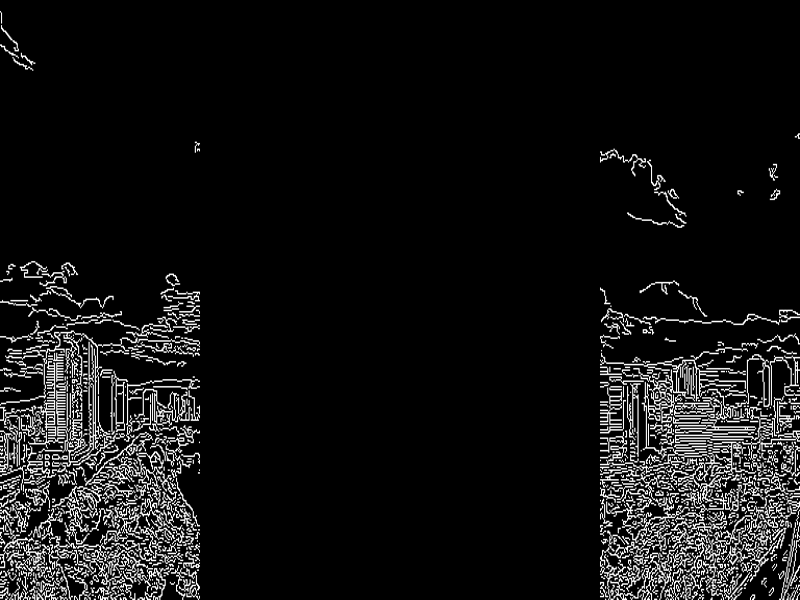

In [26]:
resized_image = canny_image.resize((800, 600))
resized_image

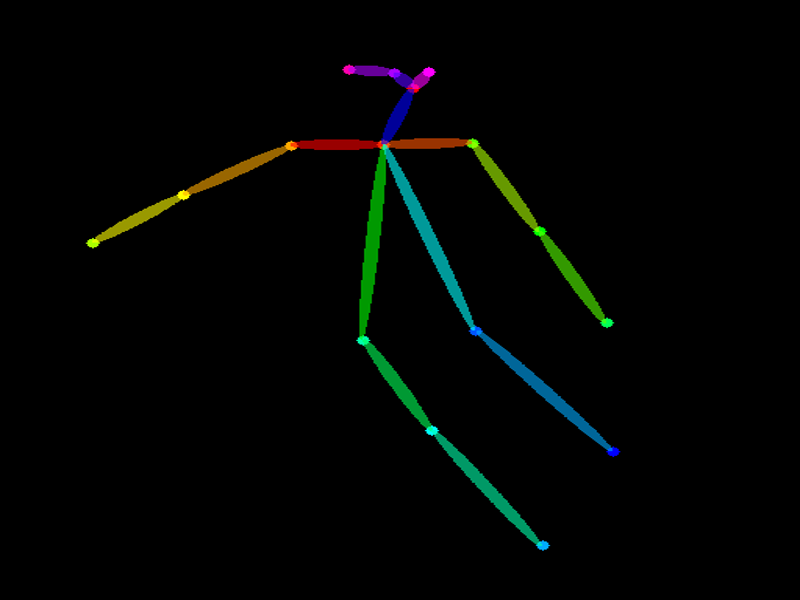

In [27]:
# 이미지를 불러옵니다.
openpose_image = load_image(
    'https://images.chosun.com/resizer/uep7vok3z5ZqVYxdbeTiMMLdqko=/616x0/smart/cloudfront-ap-northeast-1.images.arcpublishing.com/chosun/35RXYRRZF5HVLOCFWVKIWCWNTY.jpg'
)

# OpenposeDetector를 사용하여 인체 자세를 검출합니다.
openpose_image = openpose(openpose_image)
# 이미지 크기 조절
resized_image2 = openpose_image.resize((800, 600))
resized_image2

In [45]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
 # Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 만듭니다.
controlnet = [
    openpose_controlnet,
    canny_controlnet,
]

# 리스트 controlnets를 파이프라인으로 전달합니다.
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/200 [00:00<?, ?it/s]

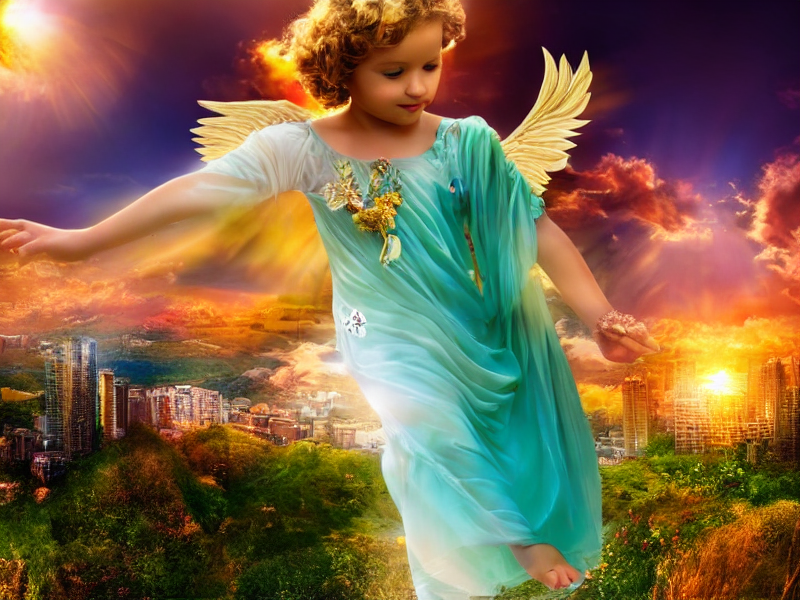

In [53]:
pipe = pipe.to("cuda")

# 프롬프트를 작성합니다.
prompt = "very cute angel standing in a peaceful fantasy landscape, best quality"
negative_prompt ="monochrome, lowres, bad anatomy, worst quality, low quality"

# seed를 지정합니다.
generator = torch.manual_seed(1)

images = [resized_image2,resized_image]

# 이미지를 생성합니다.
image = pipe(
    prompt=prompt,
    negative_prompt= negative_prompt,
    num_inference_steps=200,
    generator=generator,
    controlnet_conditioning_scale=[1.0, 0.8],
    image=images).images[0]

# 생성된 이미지를 저장합니다.
image.save("./multi_controlnet_output.png")

# 생성된 이미지를 출력합니다.
image